In [31]:
!pip install -r requirement.txt

In [32]:
import numpy as np
import geatpy as ea
import pandas as pd
import random
from datetime import datetime
print(ea.__version__)

2.7.0


### READ DATA
TODO: read data from GP

In [33]:
rawData = pd.read_excel(io='./FCI ANZ (2022-07-08) (NBV as at 30 Jun 2022)_v2.xlsx', sheet_name='Raw (portfolio)', engine='openpyxl')

In [34]:
# randomly choose 1000 samples
n = 1000
rawData = rawData.iloc[:30000, :61]

In [163]:
data = rawData.sample(n)
print(data.shape)
data.sample(3)

(1000, 61)


,Business Unit (Contract),Business Unit Am,Unit Id Fz,Cost,Po Num Fz,Mfr Dt Fz,Asset Id,Pool Fz,Product,Birth Unit Id Fz,...,Correct CEU,NP year,NBV check,age at drawdown X CEU,RML at drawdown X CEU,category,string,filter 2017 contracts,contract units,filter no. of units
15949,FZOPS,DF3RM,FFAU4026860,6000.0,CSIH-FL-2115,4/8/2021,1705583.0,DFC3,D4H,FFAU4026860,...,1.7,2021 NP,Reasonable,3.367164,10.637808,from ANZ portfolio,LT-MSC-48D4H,NaN,6997.0,1.0
27618,FZOPS,DF3RM,FDCU0072398,3682.0,DFIC-FL-1801,1/1/2018,1094423.0,DFC3,D4H,FDCU0072398,...,1.7,2018 NP,Reasonable,8.909164,11.490836,from available portfolio,LF-HAPAG-09D4H,NaN,2516.0,1.0
22700,FZOPS,DF3RM,FBIU0335980,2267.0,CIMC-FL-1804,3/22/2018,1183944.0,DFC3,D20,FBIU0335980,...,1.0,2018 NP,Reasonable,5.020685,3.545205,from available portfolio,LE-ONE-01D20,NaN,4991.0,1.0


### DATA PREPARATION

In [164]:
# TODO: add more columns later
input_data = \
    data.loc[:, ['Cost', 'Mfr Dt Fz', 'Product', 'Contract Cust Id', 'Contract Dt', 'Contract Expiration Dt', 'Nbv', 'Billing Status Fz']]
input_data.sample(3)

,Cost,Mfr Dt Fz,Product,Contract Cust Id,Contract Dt,Contract Expiration Dt,Nbv,Billing Status Fz
17960,6000.0,5/9/2021,D4H,MSC,2021-04-01,2029-06-30,5612.350,ON
29000,2182.0,1/2/2018,D20,HAPAG,2017-11-01,2030-01-31,1784.489,ON
28092,3682.0,1/3/2018,D4H,HAPAG,2017-11-01,2030-01-31,2869.540,ON


In [165]:
# select standard equipment
standardEquipment = ['D4H', 'D20', 'D40']
def SelectStandardEquip(Product):
    if Product in standardEquipment:
        Product = 1
    else:
        Product = 0
    return Product

input_data['Product'] = input_data.apply(lambda x: SelectStandardEquip(x['Product']), axis=1)
input_data.sample(3)

,Cost,Mfr Dt Fz,Product,Contract Cust Id,Contract Dt,Contract Expiration Dt,Nbv,Billing Status Fz
16683,6000.0,5/9/2021,1,MSC,2021-04-01,2029-06-30,5612.35,ON
16043,6000.0,4/8/2021,1,MSC,2021-04-01,2029-06-30,5612.35,ON
12103,4420.0,3/3/2021,1,ONE,2020-11-16,2029-05-15,4117.43,ON


Find Top 1 and Top 3 Lessees

In [166]:
# select the Top1 lessee
input_data.groupby('Contract Cust Id').count().sort_values('Cost', ascending=False)

,Cost,Mfr Dt Fz,Product,Contract Dt,Contract Expiration Dt,Nbv,Billing Status Fz
Contract Cust Id,,,,,,,
MSC,440,440,440,440,440,440,440
ONE,363,363,363,363,363,363,363
HAPAG,182,182,182,182,182,182,182
TCLC,5,5,5,5,5,5,5
COSMR,4,4,4,4,4,4,4
CMA,3,3,3,3,3,3,3
PANOCEAN,3,3,3,3,3,3,3


In [167]:
# top1 and top3 lessees 
Top1Lessee = 'MSC'
Top3Lessees = ['MSC', 'ONE', 'HAPAG']

#### Select top 1 and top 3 lessees
Assign new column `Top1Lessee` and `Top3Lessees`

In [168]:
def SelectTop1(custID):
    if custID == Top1Lessee:
        custID = 1
    else:
        custID = 0
    return custID

def SelectTop3(custID):
    if custID in Top3Lessees:
        custID = 1
    else:
        custID = 0
    return custID

input_data['Top1Lessee'] = input_data.apply(lambda x: SelectTop1(x['Contract Cust Id']), axis=1)
input_data['Top3Lessees'] = input_data.apply(lambda x: SelectTop3(x['Contract Cust Id']), axis=1)
input_data.sample(3)

,Cost,Mfr Dt Fz,Product,Contract Cust Id,Contract Dt,Contract Expiration Dt,Nbv,Billing Status Fz,Top1Lessee,Top3Lessees
29215,2182.0,1/2/2018,1,HAPAG,2017-11-01,2030-01-31,1784.486,ON,0,1
18029,6000.0,4/12/2021,1,MSC,2021-04-01,2029-06-30,5612.350,ON,1,1
19769,3849.0,4/6/2018,1,ONE,2018-02-01,2026-10-14,3123.450,ON,0,1


#### Calcualte manufacture age
Assign new column `MfrAge`

In [169]:
# TODO: consider timezone, consider time_now in the future
time_now = datetime.now()
# calculate manufacture age
date_format = '%m/%d/%Y'
# return in years, round to 2 decimal
def CalculateManufacutreAge(date):
    diff = time_now.date() - datetime.strptime(date, date_format).date()
    return round(diff.days / 365, 2)

input_data['MfrAge'] = input_data.apply(lambda x: CalculateManufacutreAge(x['Mfr Dt Fz']), axis=1)
input_data.sample(3)

,Cost,Mfr Dt Fz,Product,Contract Cust Id,Contract Dt,Contract Expiration Dt,Nbv,Billing Status Fz,Top1Lessee,Top3Lessees,MfrAge
2299,3832.0,12/18/2017,1,HAPAG,2017-11-01,2030-01-31,2981.830,ON,0,1,4.77
5145,3682.0,2/28/2018,1,MSC,2018-03-01,2032-07-31,2933.000,ON,1,1,4.57
25203,2262.0,3/21/2018,1,ONE,2018-02-01,2026-10-14,1900.264,ON,0,1,4.51


#### Calculate unexpired year 
Assign new column `ExpYear`

In [170]:
# TODO: consider timezone, consider time_now in the future
# TODO: 'Contract Expiration Dt' is in Timestamp, the data type may change
time_now = datetime.now()
# calculate manufacture age
date_format = '%Y-%m-%d'
# return in years, round to 2 decimal
def CalculateExpYear(date):
    diff = pd.to_datetime(date,format="%Y%m%d").date() - time_now.date()
    return round(diff.days / 365, 2)

input_data['ExpYear'] = input_data.apply(lambda x: CalculateExpYear(x['Contract Expiration Dt']), axis=1)
input_data.sample(3)

,Cost,Mfr Dt Fz,Product,Contract Cust Id,Contract Dt,Contract Expiration Dt,Nbv,Billing Status Fz,Top1Lessee,Top3Lessees,MfrAge,ExpYear
8819,5150.0,4/20/2021,1,MSC,2021-04-01,2029-06-30,4773.96,ON,1,1,1.43,6.77
15515,6000.0,4/8/2021,1,MSC,2021-04-01,2029-06-30,5612.35,ON,1,1,1.46,6.77
9842,4420.0,3/24/2021,1,ONE,2020-11-16,2029-05-15,4136.34,ON,0,1,1.50,6.65


Select billing status

In [171]:
def SelectBilling(status):
    if status == 'ON':
        status = 1
    else:
        status = 0
    return status

input_data['Billing Status Fz'] = input_data.apply(lambda x: SelectBilling(x['Billing Status Fz']), axis=1)
input_data.sample(3)

,Cost,Mfr Dt Fz,Product,Contract Cust Id,Contract Dt,Contract Expiration Dt,Nbv,Billing Status Fz,Top1Lessee,Top3Lessees,MfrAge,ExpYear
19524,3849.0,4/6/2018,1,ONE,2018-02-01,2026-10-14,3123.450,1,0,1,4.47,4.06
710,3832.0,12/18/2017,1,HAPAG,2017-11-01,2030-01-31,2981.836,1,0,1,4.77,7.36
28814,2182.0,1/2/2018,1,HAPAG,2017-11-01,2030-01-31,1784.485,1,0,1,4.73,7.36


Save data

In [172]:
input_data.to_csv('prepared_data.csv')

In [173]:
prepared_data = pd.read_csv('./prepared_data.csv')
prepared_data.head(3)

,Unnamed: 0,Cost,Mfr Dt Fz,Product,Contract Cust Id,Contract Dt,Contract Expiration Dt,Nbv,Billing Status Fz,Top1Lessee,Top3Lessees,MfrAge,ExpYear
0,20177,3849.0,4/6/2018,1,ONE,2018-02-01,2026-10-14,3123.45,1,0,1,4.47,4.06
1,13720,6007.0,4/28/2021,1,MSC,2021-04-01,2029-06-30,5618.80,1,1,1,1.41,6.77
2,16154,6000.0,5/9/2021,1,MSC,2021-04-01,2029-06-30,5612.35,1,1,1,1.38,6.77


### Model Part

#### Input

In [174]:
# TODO: set input
prepared_data.describe()

,Unnamed: 0,Cost,Product,Nbv,Billing Status Fz,Top1Lessee,Top3Lessees,MfrAge,ExpYear
count,1000.000000,1000.00000,1000.0,1000.000000,1000.0,1000.000000,1000.000000,1000.000000,1000.000000
mean,15325.580000,4040.91494,1.0,3506.057080,1.0,0.440000,0.985000,3.442420,6.694950
std,8490.514057,1280.58229,0.0,1333.742401,0.0,0.496635,0.121613,1.510217,2.000114
min,14.000000,2182.00000,1.0,1784.484000,1.0,0.000000,0.000000,1.340000,1.020000
25%,8102.000000,3682.00000,1.0,2869.540000,1.0,0.000000,1.000000,1.460000,4.060000
50%,15575.000000,3832.00000,1.0,2981.836000,1.0,0.000000,1.000000,4.510000,6.770000
75%,22356.250000,5150.00000,1.0,4773.958000,1.0,1.000000,1.000000,4.570000,7.360000
max,29985.000000,6007.00000,1.0,5618.800000,1.0,1.000000,1.000000,4.780000,9.860000


In [16]:
nbv = prepared_data['Nbv'].to_numpy().reshape(n, 1)
product = prepared_data['Product'].to_numpy()
mfrAge = prepared_data['MfrAge'].to_numpy().reshape(n, 1)
nbv.shape, product.shape, mfrAge.shape

((1000, 1), (1000,), (1000, 1))

#### Constraints

(Nbv of standard) / (Nbv total) <= 80%: `sum(x*Product*Nbv) / sum(x*Nbv) <= 0.8`

Avg age of equip <= 3.75: TODO

Avg age of Manufaturing < 7: `sum(x*MfrAge) / sum(x) <= 7`

Equipment port subject to lease >= 90%: TODO

Avg unexpired term under leases >= 5: `sum(x*Billing Status Fz*ExpYear) / sum(x*Billing Status Fz) >= 5`

Top 1 NBV <= 50%: `sum(x*Top1Lessee*Nbv) / sum(x*Nbv) <= 0.5`

Top 3 NBV <= 70%: `sum(x*Top3Lessee*Nbv) / sum(x*Nbv) <= 0.7`

#### Objective

$max Nbv$: `max(x*Nbv)`

#### Define Problem
Define objective function and constraint functions

In [175]:
debug = 0
def DEMO():
    class MyProblem(ea.Problem):
        def __init__(self):
            name ='MyProblem'
            M = 1
            maxormins = [-1] # -1: max, 1: min
            Dim = n # num of variables
            varTypes = [1] * Dim # integers: 0 or 1
            lb = [0] * Dim # low bound
            ub = [1] * Dim # up bound
            lbin = [1] * Dim # low bound include
            ubin = [1] * Dim # up bound include
            ea.Problem.__init__(self, name, M, maxormins, Dim, varTypes, lb,ub, lbin, ubin)
            
        def aimFunc(self, pop):
            Vars = pop.Phen
            
            # two optimization methods are showed below. now we only care the first one.
            if (1):
                pop.ObjV = Vars @ nbv
                
#                 sum(x*MfrAge) / sum(x) <= 7
                
                pop.CV = np.hstack([
                    (Vars * product @ nbv) / (Vars @ nbv) - 1, # set to 0.8 later
                    (Vars @ mfrAge) / Vars.sum(axis=1, keepdims=True) - 7
                ])
                if debug:
                    print(pop.ObjV.shape)
                    print(pop.CV.shape)
                    print(pop.CV)
                    raise SystemExit
            else:
                # convert constraint problem to no-constaint problem
                # objective function
                f = 4*x1 + 2*x2 + x3
                # find the index of instances that violate constraints
                exIdx1 = np.where(2*x1 + x2 > 1)[0]
                exIdx2 = np.where(x1 + 2*x3 > 2)[0]
                exIdx3 = np.where(x1 + x2 + x3 != 1)[0]
                exIdx = np.unique(np.hstack([exIdx1, exIdx2, exIdx3]))
                alpha = 2
                beta = 1
                f[exIdx] += self.maxormins[0] * alpha * (np.max(f) - np.min(f) + beta)
                # set objective function
                pop.ObjV = f 


    problem = MyProblem()
    Encoding ='RI'
    NIND = 100 # init number of population instance
    Field = ea.crtfld(Encoding, problem.varTypes, problem.ranges,problem.borders)
    population = ea.Population(Encoding, Field, NIND)

    # set parameters
    myAlgorithm = ea.soea_DE_best_1_L_templet(problem, population)
    myAlgorithm.MAXGEN = 10000
    myAlgorithm.mutOper.F = 0.5
    myAlgorithm.recOper.XOVR = 0.7
    myAlgorithm.logTras = 1
    myAlgorithm.trappedValue = 1e-6
    myAlgorithm.maxTrappedCount = 200

    # TODO: random seed has a significant influence on final result!
    res = ea.optimize(myAlgorithm, seed=2049, verbose=False, drawing=1, outputMsg=True, drawLog=False, saveFlag=False, dirName='result')
    # do not show intermediate results, show final results

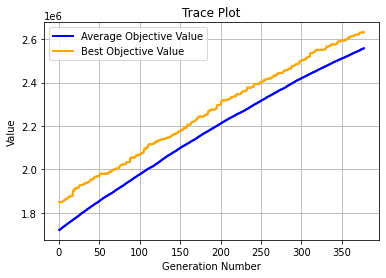

Execution time: 1.8037545680999756 s
Evaluation number: 37700
The best objective value is: 2631318.284
The best variables are: 
0	1	1	1	1	0	0	0	1	0	1	1	1	1	1	1	1	1	1	0	1	1	0	0	1	0	1	0	1	0	1	0	1	1	1	0	1	1	1	1	1	0	1	0	1	0	1	0	0	1	1	0	1	0	0	1	0	1	0	1	1	0	0	1	1	1	1	1	1	1	0	1	0	1	1	1	1	1	1	1	1	0	1	1	1	1	1	1	1	1	1	0	1	1	0	1	1	0	1	1	1	1	1	1	1	1	1	1	1	1	0	1	0	1	1	0	1	0	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	0	0	1	1	0	1	0	1	1	1	1	1	1	1	0	1	1	1	0	1	1	1	0	1	1	1	1	1	1	1	1	1	1	1	1	1	1	0	1	1	1	1	0	1	1	1	1	0	1	1	1	1	0	1	1	0	1	1	1	1	1	0	1	1	1	0	0	1	1	1	1	0	1	0	1	1	0	1	0	1	1	1	1	1	0	0	0	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	0	0	1	1	1	1	0	1	0	1	1	1	1	0	0	0	0	1	0	0	0	0	1	1	1	0	1	1	1	1	1	0	0	1	1	0	1	0	1	1	1	1	0	1	0	0	1	1	1	1	0	1	1	0	0	1	1	1	0	1	1	1	1	1	0	1	1	1	1	1	1	1	1	1	1	1	1	1	0	1	1	1	1	0	1	1	0	1	1	1	1	1	0	1	1	0	1	1	1	1	1	1	1	0	0	1	1	1	1	0	0	1	1	1	1	1	1	0	1	1	1	1	1	1	1	1	1	1	1	0	0	0	0	1	0	0	0	1	1	1	1	1	1	1	1	1	1	0	0	0	1	0	1	1	1	0	1	0	1	0	0	0	1	1	0	1	0	1	0	1	1	1	1	1	1	1	1	1	1	1	0	0	1	1	1	0	1	0	1	1	1	0	0	0	1	1	0	

In [176]:
DEMO()